In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install ase
import ase #package called Atomic Simulation Environment which allows us to construct crystals easily
from ase.spacegroup import crystal
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from tqdm import tqdm
from ase.io import read, write
!pip install crystals
from crystals import Crystal

In [2]:
# Script to create crystal using crystals package and cif, as well as reformat the output lmp file so lammps can read it
#@author: wuaudrey, adapted from code by kmream

#crystals crystal method - quartz
quartz = Crystal.from_cif('9005017.cif') #can be a file from the crystallography open database or exported from crystalmaker
quartz = quartz.to_ase() #converts to ase formatting for ease of use
print(f"cif file crystal dimensions {quartz.get_cell_lengths_and_angles}")

quartz *= (100,100,100) #scale to get desired dimensions
print(f"final crystal dimensions {quartz.get_cell_lengths_and_angles}")

write("quartz_cell.lmp", quartz, format="lammps-data", specorder=['Si', 'O'])

mass1 = 28.086 #Si    -- edit these as needed
mass2 = 15.999 #O
mass3=196.967 #Au

write("quartz_cell.lmp", quartz, format='lammps-data', specorder=['Si', 'O'])

with open('quartz_cell.lmp', 'w') as f:
    f.write("ID Type x y z\n")
    for i, atom in enumerate(quartz, start=1):
        atom_type = atom.number  # or use a mapping from symbol if needed
        x, y, z = atom.position
        f.write(f"{i} {atom_type} {x:.6f} {y:.6f} {z:.6f}\n")

cif file crystal dimensions <bound method Atoms.get_cell_lengths_and_angles of Atoms(symbols='O3SiO2Si2O', pbc=False, cell=[[4.255389026575598, -2.4568499999999993, 3.008773488485175e-16], [0.0, 4.9137, 3.008773488485175e-16], [0.0, 0.0, 5.4047]], initial_magmoms=..., masses=...)>
final crystal dimensions <bound method Atoms.get_cell_lengths_and_angles of Atoms(symbols='O6000000Si3000000', pbc=False, cell=[[425.5389026575598, -245.68499999999995, 3.008773488485175e-14], [0.0, 491.37000000000006, 3.008773488485175e-14], [0.0, 0.0, 540.47]], initial_magmoms=..., masses=...)>


In [7]:
data = pd.read_csv('quartz_cell.lmp', sep = " ")
data.loc[data['Type'] == 14, 'Type'] = 1
data.loc[data['Type'] == 8, 'Type'] = 2
charge_map = {1: 1.0, 2: -0.5}
data['Charge'] = data['Type'].map(charge_map)
charge_col = data.pop('Charge')
data.insert(2, 'Charge', charge_col)
data

xcut, ycut, zcut = 300,300,300

def cutoff(data):
    data_new = data[(data['x'] <= xcut)]
    data_new = data_new[data_new['y'] <= ycut]
    data_new = data_new[data_new['z'] <= zcut]
    data_new = data_new[data_new['x'] >= 0]
    data_new = data_new[data_new['y'] >= 0]
    data_new = data_new[data_new['z'] >= 0]
    return data_new

def center_data(data):
  mean_x = data['x'].mean()
  mean_y = data['y'].mean()
  mean_z = data['z'].mean()
  data['x'] = data['x'] - mean_x
  data['y'] = data['y'] - mean_y
  data['z'] = data['z'] - mean_z
  return data

data = cutoff(data)
data = center_data(data)
data = data.reset_index(drop=True)
data['ID'] = data.index + 1
data

,ID,Type,Charge,x,y,z
0,1,2,-0.5,-147.390953,-146.973075,-148.667497
1,2,2,-0.5,-146.253913,-148.942486,-147.383340
2,3,1,1.0,-149.887590,-147.419485,-146.223852
3,4,2,-0.5,-148.750550,-148.353088,-146.865930
4,5,2,-0.5,-149.265878,-146.485636,-145.064363
...,...,...,...,...,...,...
2151892,2151893,1,1.0,149.988398,148.854268,125.812715
2151893,2151894,1,1.0,149.988398,148.854268,131.217415
2151894,2151895,1,1.0,149.988398,148.854268,136.622115
2151895,2151896,1,1.0,149.988398,148.854268,142.026815


In [8]:
write("quartz_cell_cut.lmp", quartz, format='lammps-data', specorder=['Si', 'O'])

xlo, xhi = data['x'].min(), data['x'].max()
ylo, yhi = data['y'].min(), data['y'].max()
zlo, zhi = data['z'].min(), data['z'].max()

data = pd.DataFrame(data)

with open('quartz_cell_cut.lmp', 'w') as f:
  '''reformats file so lammps can read it properly
    all notations that follow a '#' symbol are optional and are for clarity'''
  f.write('Quartz 9005017.cif, Kihara 1990, sample at 298K) \n') #title line
  f.write('\n')
  print(len(data), 'atoms', file=f)
  f.write('3 atom types \n') #change to match your crystal, keep plural even for singular type
  f.write('\n')
  pad = 5.0
  #f.write(f"{xlo - pad:.6f} {xhi + pad:.6f} xlo xhi\n")
  f.write(f"-100 400 xlo xhi\n") #modify the direction which you're shooting the gold ion to be much longer
  f.write(f"{ylo - pad:.6f} {yhi + pad:.6f} ylo yhi\n")
  f.write(f"{zlo - pad:.6f} {zhi + pad:.6f} zlo zhi\n\n")
  #f.write('{xmin} 150.0 xlo xhi \n') #change to fit the dimensions you need
  #f.write('-20.0 110.0 ylo yhi \n')
  #f.write('-20.0 110.0 zlo zhi \n')
  f.write('\n')
  f.write('Masses \n')
  f.write('\n')
  print('1', mass1, '#Si', file=f)
  print('2', mass2, '#O', file=f)
  print('3', mass3, '#Au \n', file=f)
  f.write(f"Atoms #charge [{xcut},{ycut},{zcut}] \n")
  f.write('\n')

  for _, row in data.iterrows():
        f.write(f"{int(row['ID'])} {int(row['Type'])} {(row['Charge'])} {row['x']} {row['y']} {row['z']}\n")
      #f.write(f"{i} {atom_type} {x:.6f} {y:.6f} {z:.6f}\n")
      #f.write(f"{i} {atom_type} {atom_charge} {x:.6f} {y:.6f} {z:.6f} \n") #substitute this line instead of the above if atom charge is wanted

<ipython-input-9-2216873769>:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


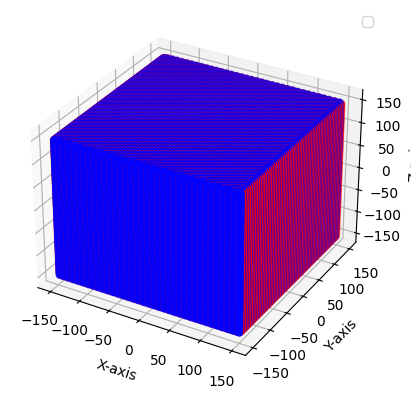

In [9]:
#prints a 3D visualization of your crystal

colors = data['Type'].map({1: 'red', 2: 'blue'}) #assign colors to atoms as needed

#colors = ['red' if atom_type == 1 else 'blue' for atom_type in data['Type']] #assign colors to atoms as needed

from csv import field_size_limit
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data['x'], data['y'], data['z'], c = colors)

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

plt.legend()
plt.show()

with open("quartz_cell_cut.lmp", "r") as file:
  in_atoms = False
  for i, line in enumerate(file):
      if "Atoms" in line:
        in_atoms = True
        continue
      if in_atoms:
        if line.strip() == "":
          break
        parts = line.split()
        if len(parts) != 6:
            print(f"Line {i+1} malformed: {line}")

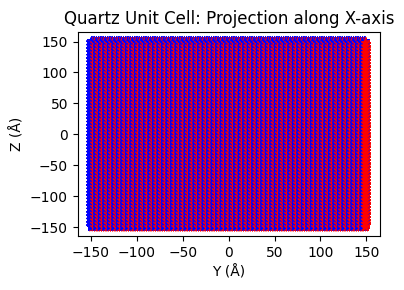

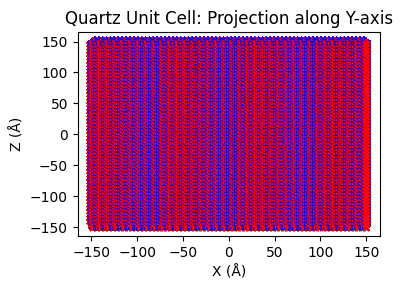

<ipython-input-10-2160018681>:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


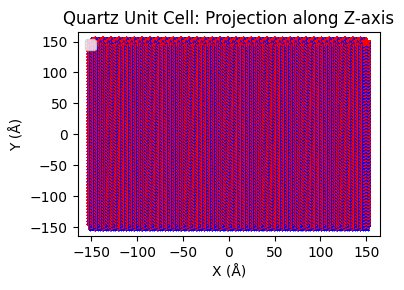

In [10]:
#prints 2D projections of your crystal

fig, ax = plt.subplots(figsize=(4, 3))
plt.scatter(data['y'], data['z'], c = colors, marker = '*')

ax.set_xlabel("Y (Å)")
ax.set_ylabel("Z (Å)")
plt.title("Quartz Unit Cell: Projection along X-axis")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(4, 3))
plt.scatter(data['x'], data['z'], c = colors, marker = '*')

ax.set_xlabel("X (Å)")
ax.set_ylabel("Z (Å)")
plt.title("Quartz Unit Cell: Projection along Y-axis")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(4, 3))
plt.scatter(data['x'], data['y'], c = colors, marker = '*')

ax.set_xlabel("X (Å)")
ax.set_ylabel("Y (Å)")
plt.title("Quartz Unit Cell: Projection along Z-axis")
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
#code to check if there are any duplicated atoms in your crystal file (there shouldn't be, but this is a step of troubleshooting)

import pandas as pd

duplicates = data.duplicated(subset=['x', 'y', 'z'])
print(f"these are the duplicates: {duplicates}") #print the boolean series indicating duplicates
duplicate_rows = df[duplicates] #to get the actual duplicate rows
print(f"these are the duplicate rows: {duplicate_rows}")